In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin

from glob import glob

import librosa, librosa.display
import IPython.display as ipd
import noisereduce as nr
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/My Drive/MachineLearning/Colab data/VoxCeleb_gender.zip"

extract_path = '/content/unzipped_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Data exploration

In [ ]:
males_data = glob('/content/unzipped_data/VoxCeleb_gender/males/*')
females_data = glob('/content/unzipped_data/VoxCeleb_gender/females/*')
len(males_data), len(females_data)

(3682, 2311)

In [ ]:
# test a male audio file
males_data[0]

'/content/unzipped_data/VoxCeleb_gender/males/796.m4a'

In [ ]:
y, sr = librosa.load(males_data[0], sr=None)
print(f"Shape of y: {y.shape}")
print(f"Sample rate: {sr}")
print(f"Duration of audio: {librosa.get_duration(y=y, sr=sr)} seconds")
print(f"y itself: {y[:10]}")

Shape of y: (89088,)
Sample rate: 16000
Duration of audio: 5.568 seconds
y itself: [-0.07058716 -0.07519531 -0.0604248  -0.04211426 -0.02896118  0.01141357
  0.02459717  0.019104   -0.02127075 -0.04940796]


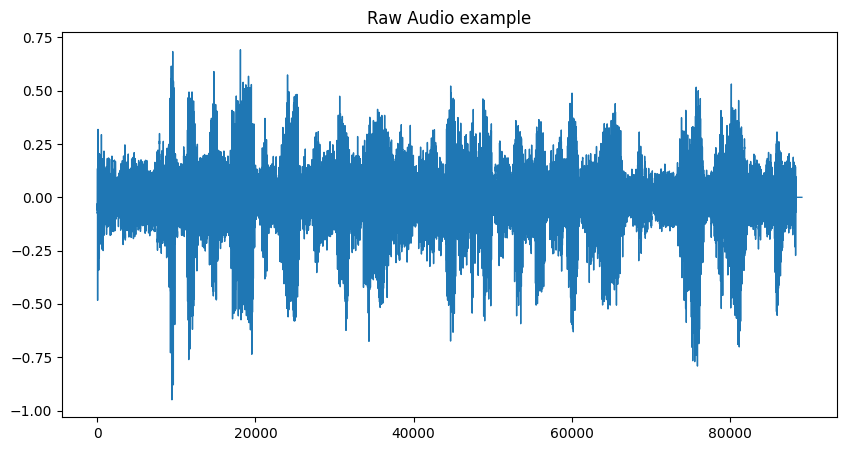

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example")
plt.show()

In [ ]:
# test a female audio file
ipd.Audio(females_data[2])

In [ ]:
y, sr = librosa.load(females_data[2])
print(f"Shape of y: {y.shape}")
print(f"Sample rate: {sr}")
print(f"Duration of audio: {librosa.get_duration(y=y, sr=sr)} seconds")
print(f"y itself: {y[:10]}")

Shape of y: (138298,)
Sample rate: 22050
Duration of audio: 6.272018140589569 seconds
y itself: [ 0.24249703  0.31371248  0.3083152   0.3221162   0.29437953  0.22460619
  0.16750687  0.08516347 -0.01413598 -0.08627422]


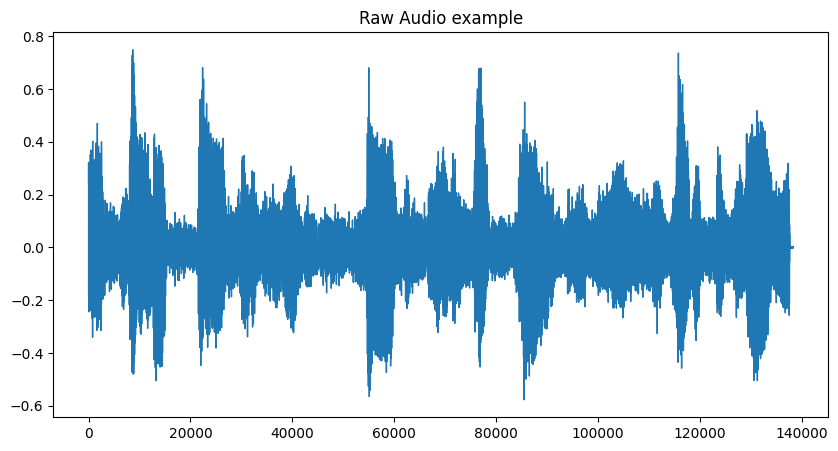

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example")
plt.show()

### Noise reduction

In [ ]:
y_reduced, srr = librosa.load(males_data[0], sr=None)
reduced_noise = nr.reduce_noise(y=y, sr=srr)
ipd.Audio(reduced_noise, rate=sr)

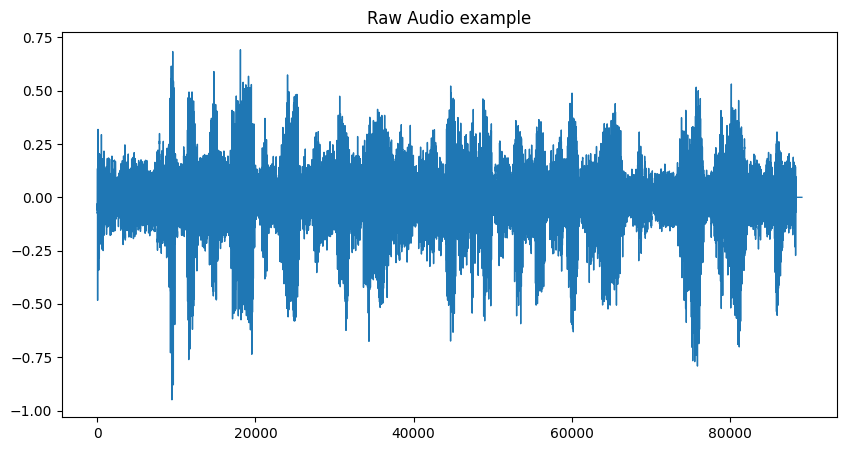

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example")
plt.show()

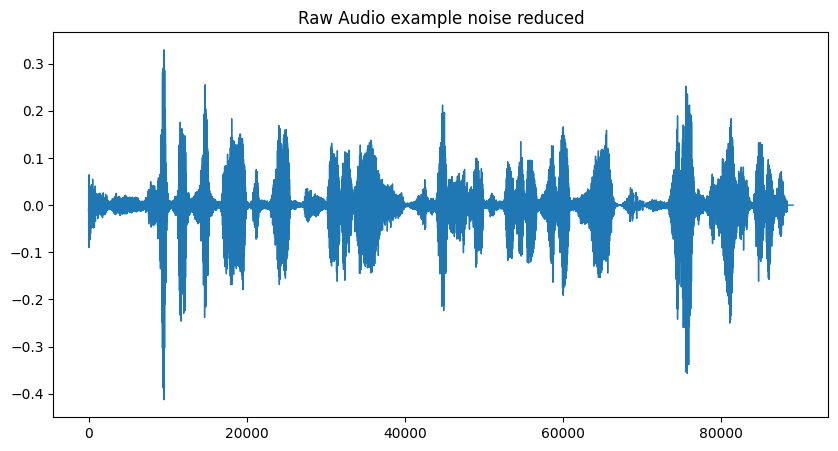

In [ ]:
pd.Series(reduced_noise).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example noise reduced")
plt.show()

In [ ]:
reduced_noise[:10]

array([-0.00806595, -0.01169024, -0.0145164 , -0.01437659, -0.01263245,
       -0.00859166, -0.00624064, -0.00551469, -0.00816209, -0.01070898],
      dtype=float32)

In [ ]:
y[:10]

array([-0.07058716, -0.07519531, -0.0604248 , -0.04211426, -0.02896118,
        0.01141357,  0.02459717,  0.019104  , -0.02127075, -0.04940796],
      dtype=float32)

In [ ]:
ipd.Audio(y, rate=sr)

In [ ]:
ipd.Audio(reduced_noise, rate=srr)

### cleaning data

In [99]:
def data_preprocessing(audio_file):
  #noise reduce
  y, sr = librosa.load(audio_file, sr=None)
  y_reduced = nr.reduce_noise(y=y, sr=sr)
  #silence removal
  y = librosa.effects.trim(y_reduced, top_db=30)[0]
  return y

In [ ]:
cleaned_data = []
for audio in males_data:
  cleaned_data.append([data_preprocessing(audio), 'male'])
for audio in females_data:
  cleaned_data.append([data_preprocessing(audio), 'female'])


In [ ]:
print(cleaned_data[0][1])

male


In [ ]:
# saving cleaned dataset
import soundfile as sf
output_folder_males = '/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/males'
output_folder_females = '/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/females'

os.makedirs(output_folder_males, exist_ok=True)
os.makedirs(output_folder_females, exist_ok=True)

i = 0
for data in cleaned_data:
  if data[1] == 'male':
    sf.write(os.path.join(output_folder_males, f'audio_{i}.wav'), data[0], 16500)
  else:
    sf.write(os.path.join(output_folder_females, f'audio_{i}.wav'), data[0], 16500)
  i += 1


We saved the cleaned dataset in the drive in order to be able to use it if we restarted the session.

In [ ]:
ipd.Audio(cleaned_data[4000][0], rate=16500)

In [ ]:
#Loading the cleaned dataset
cleaned_males = glob('/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/males/*')
cleaned_females = glob('/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/females/*')

# Features Extraction

In [ ]:
# feature extraction
features_list = []
for audio in cleaned_males:
  audio = librosa.load(audio, sr=14500)
  #Mel-frequency mestral coefficients: captures vocal shape
  mfcc = librosa.feature.mfcc(y=audio[0], sr=14500, n_mfcc=20)
  mfcc_mean = np.mean(mfcc.T, axis=0)
  #Spectral centroid: helps in differentiating between male and female voices (females voices tend to have higher spectral centroid)
  spectral_centroid = librosa.feature.spectral_centroid(y=audio[0], sr=14500)
  centroid_mean = spectral_centroid.mean()
  features_list.append([mfcc_mean, centroid_mean, 'male'])

for audio in cleaned_females:
  audio = librosa.load(audio, sr=14500)
  #mfcc
  mfcc = librosa.feature.mfcc(y=audio[0], sr=14500, n_mfcc=20)
  mfcc_mean = np.mean(mfcc.T, axis=0)
  #spectral centroid
  spectral_centroid = librosa.feature.spectral_centroid(y=audio[0], sr=14500)
  centroid_mean = spectral_centroid.mean()
  features_list.append([mfcc_mean, centroid_mean, 'female'])

In [ ]:
df = pd.DataFrame(features_list, columns=['mfcc', 'centroid', 'label'])
df.tail()

mfcc     centroid   label
5988  [-347.7634, 97.00572, -24.55413, 6.274897, -27...  1614.664532  female
5989  [-459.91214, 31.165327, -17.704473, 2.4931598,...  2281.390636  female
5990  [-447.45297, 104.281525, -6.40199, 13.323459, ...  1604.366185  female
5991  [-493.04065, 69.06094, 20.785162, 31.36477, -1...  2423.374966  female
5992  [-454.0899, 81.557945, 20.217226, 17.75264, -6...  1928.198086  female

In [ ]:
df['mfcc'][0]

array([-5.8547650e+02,  1.3707797e+02,  9.7948036e+00,  1.2273837e+00,
       -4.8812046e+00, -1.2920576e+01, -2.7551512e+01, -1.0630464e+01,
       -1.0225467e+01,  5.2975732e-01,  2.4795728e+00, -6.2119517e+00,
        3.5785124e+00,  9.8371792e+00,  7.1664011e-01, -1.2912334e+00,
        2.0044835e+00, -3.5387425e+00, -8.8749428e+00, -4.6858664e+00],
      dtype=float32)

In [ ]:
mfcc = df.mfcc.tolist()
centroid = df.centroid.tolist()
X = np.hstack([np.asarray(mfcc).reshape(len(mfcc), -1), np.asarray(centroid).reshape(len(centroid), -1)])
Y = np.array(df.label.tolist())

In [ ]:
Y[0]

np.str_('male')

In [ ]:
X.shape

(5993, 21)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
# Saving the numpy arrays to be able to use them later, since these are the features that we'll use in the model.
np.save('/content/drive/My Drive/MachineLearning/Colab data/features.npy', X)
np.save('/content/drive/My Drive/MachineLearning/Colab data/labels.npy', Y)

# Data preprocessing finished: Loading final data

In [3]:
X = np.load('Dataset/features.npy')
Y = np.load('Dataset/labels.npy')

In [ ]:
X.shape

(5993, 21)

In [ ]:
Y.shape

(5993,)

# Splitting dataset

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Naive Bayes from scratch

In [5]:
class NaiveBayes(BaseEstimator, ClassifierMixin):
    def __init__(self, var_smoothing=1e-9):
        self.var_smoothing = var_smoothing  # smoothing parameter
        self.classes_ = None
        self.class_priors_ = None
        self.feature_stats_ = None

    def get_params(self, deep=True):
        """Get parameters for this estimator"""
        return {"var_smoothing": self.var_smoothing}

    def set_params(self, **params):
        """Set the parameters of this estimator"""
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)


    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [11]:
def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred) / len(y_true)
  return accuracy

nb = NaiveBayes()
nb.fit(X_train,y_train)
predictions = nb.predict(X_test)
print("accuracy:", accuracy(y_test, predictions))

accuracy: 0.8865721434528774


# Bagging using Naive Bayes

In [9]:
nb = NaiveBayes()

# 4. Create Bagging ensemble of Naïve Bayes classifiers
nb_bagging = BaggingClassifier(
    estimator = nb,
    n_estimators=10,  # number of Naïve Bayes models to train
    max_samples=0.8,  # fraction of data to use for each subset
    random_state=42
)

# 5. Train the ensemble
nb_bagging.fit(X_train, y_train)

# 6. Make predictions
y_pred_nb_bagging = nb_bagging.predict(X_test)

# 7. Evaluate performance
accuracy_nb_bagging = accuracy(y_test, y_pred_nb_bagging)
print(f"Naïve Bayes Bagging Accuracy: {accuracy_nb_bagging:.4f}")

# 8. Compare with single Naïve Bayes model
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
accuracy_nb = accuracy(y_test, y_pred_nb)
print(f"Single Naïve Bayes Accuracy: {accuracy_nb:.4f}")

Naïve Bayes Bagging Accuracy: 0.8874
Single Naïve Bayes Accuracy: 0.8866


# Bagging using Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000, random_state=42)

# 2. Create Bagging ensemble of Logistic Regression models
lr_bagging = BaggingClassifier(
    estimator =lr,
    n_estimators=10,
    max_samples=0.8,
    random_state=42,
)

# 3. Train the ensemble
lr_bagging.fit(X_train, y_train)

# 4. Make predictions
y_pred_lr_bagging = lr_bagging.predict(X_test)

# 5. Evaluate performance
accuracy_lr_bagging = accuracy(y_test, y_pred_lr_bagging)
print(f"Logistic Regression Bagging Accuracy: {accuracy_lr_bagging:.4f}")

# 6. Compare with single Logistic Regression model
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy(y_test, y_pred_lr)
print(f"Single Logistic Regression Accuracy: {accuracy_lr:.4f}")


Logistic Regression Bagging Accuracy: 0.8932
Single Logistic Regression Accuracy: 0.8932


# User Input

In [101]:
#testing microphone
import pyaudio
import wave
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000

p = pyaudio.PyAudio()

stream = p.open(
    format=FORMAT,
    channels=CHANNELS,
    rate=RATE,
    input=True,
    frames_per_buffer=FRAMES_PER_BUFFER
)

print('start recording')

seconds = 5
frames = []
for i in range(0, int(RATE/FRAMES_PER_BUFFER * seconds)):
  data = stream.read(FRAMES_PER_BUFFER)
  frames.append(data)

stream.stop_stream()
stream.close()
p.terminate()

#saving to wave file
obj = wave.open("output.wav", "wb")
obj.setnchannels(CHANNELS)
obj.setsampwidth(p.get_sample_size(FORMAT))
obj.setframerate(RATE)
obj.writeframes(b"".join(frames))
obj.close()

start recording


In [118]:
soundfile = glob("audio_5970.wav")
soundfile

['audio_5970.wav']

In [119]:
ipd.Audio(soundfile[0])

In [41]:
label_map = {
    0: "female",
    1: "male"
}

In [121]:
def data_preparation(sound):
    feature = []
    y = data_preprocessing(sound)
    mfcc = librosa.effects.feature.mfcc(y=y, sr=16500, n_mfcc=20)
    mfcc_mean = np.mean(mfcc.T, axis=0)
    spectral_centroid = librosa.effects.feature.spectral_centroid(y=y, sr=16500)
    centroid_mean = spectral_centroid.mean()
    
    feature.append([mfcc_mean, centroid_mean])
    return feature

x = data_preparation(soundfile[0])
x = np.hstack([np.asarray(x[0][0]), np.asarray(x[0][1])])
x = x.reshape(1, -1)
label_map[nb.predict(x)[0]]

'female'

# Testing built-in models on the dataset

In [ ]:
#using built-in naive bayes classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create a Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
nb_classifier.score(X_test, y_test)

0.8865721434528774

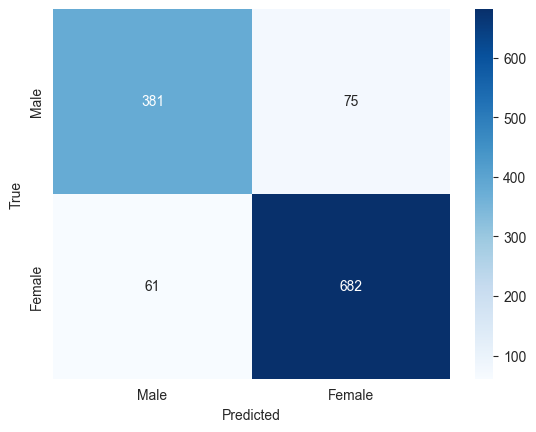

In [52]:
from sklearn.metrics import confusion_matrix
y_pred = nb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
len(X_test)

1199

In [ ]:
# trying svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
svm_classifier.score(X_test, y_test)

0.8940783986655546

In [ ]:
# trying logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
lr.score(X_test, y_test)

0.890742285237698